In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


In [2]:
(X_Train,_),(_,_) = mnist.load_data()

In [3]:
print(X_Train.shape)

(60000, 28, 28)


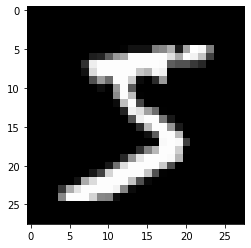

In [4]:
plt.imshow(X_Train[0],cmap='gray')
plt.show()

In [5]:
# Normalize this data [-1,1] 
X_Train  = (X_Train.astype('float32') - 127.5)/127.5
print(np.min(X_Train))
print(np.max(X_Train))

print(X_Train.shape)

-1.0
1.0
(60000, 28, 28)


In [6]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(X_Train.shape[0]/BATCH_SIZE) 
HALF_BATCH = 128
NOISE_DIM = 100 # Upsample into 784 Dim Vector
adam = Adam(lr=2e-4,beta_1=0.5)

In [7]:
# Generator 
# Input Noise (100 dim) and Outputs a Vector (784 dim)

generator = Sequential()
generator.add(Dense(256,input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer=adam)
generator.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [8]:
# Downsampling 
discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer=adam)

discriminator.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [9]:
# GAN (Step-2)
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)


In [10]:
X_Train = X_Train.reshape(-1,784)
print(X_Train.shape)

(60000, 784)


In [11]:
def save_imgs(epoch,samples=100):
    
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis("off")
        
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

In [12]:
# Training Loop
d_losses = []
g_losses = []


for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    #Mini Batch SGD
    for step in range(NO_OF_BATCHES):
        
        # Step-1 Discriminator 
        # 50% Real Data + 50% Fake Data
        
        #Real Data X
        idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH)
        real_imgs = X_Train[idx]
        
        #Fake Data X
        noise = np.random.normal(0,1,size=(HALF_BATCH,NOISE_DIM))
        fake_imgs = generator.predict(noise) #Forward 
        
        
        # Labels 
        real_y = np.ones((HALF_BATCH,1))*0.9 #One Side Label Smoothing for Discriminator
        fake_y = np.zeros((HALF_BATCH,1))
        
        # Train our Discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
        
        epoch_d_loss += d_loss
        
        # Train Generator (Considering Frozen Discriminator)
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        ground_truth_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,ground_truth_y)
        epoch_g_loss += g_loss
        
    print("Epoch %d Disc Loss %.4f Generator Loss %.4f" %((epoch+1),epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
    d_losses.append(epoch_d_loss/NO_OF_BATCHES)
    g_losses.append(epoch_g_loss/NO_OF_BATCHES)
    
    if (epoch+1)%5==0:
        generator.save('model/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)
        
        
        
        

InternalError:  Blas GEMM launch failed : a.shape=(32, 100), b.shape=(100, 256), m=32, n=256, k=100
	 [[node dense_1/MatMul (defined at C:\Users\Dibakar Chaudhary\Anacondanew\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_keras_scratch_graph_390]

Function call stack:
keras_scratch_graph


In [ ]:
!mkdir images

In [ ]:
!ls

In [ ]:
!zip -r /content/images.zip /content/images 

In [ ]:
from google.colab import files
files.download('images.zip')

In [ ]:
plt.plot(d_losses,label="Disc")
plt.plot(g_losses,label="Gen")
plt.legend()
plt.show()
